In [1]:
import numpy as np
import pandas as pd 
import fasttext
import bz2
from sklearn.metrics import roc_auc_score
import os
import re
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [27]:
data = bz2.BZ2File("train.ft.txt.bz2")
data = data.readlines()
data = [x.decode('utf-8') for x in data]

### ROC AUC score was chosen as target metric, since it usually shows quite reliable results in tasks with 2 classes and has such advantages as independency of treshold value and other. 

### Soft baseline

In [28]:
#Clearing the data
data = pd.DataFrame(data)
data.to_csv("train.txt", index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

#Building a model 
model = fasttext.train_supervised('train.txt',label_prefix='__label__', thread=4, epoch = 10)
print(model.labels)

['__label__2', '__label__1']


In [29]:
#Test data
test = bz2.BZ2File("test.ft.txt.bz2")
test = test.readlines()
test = [x.decode('utf-8') for x in test]

In [30]:
#Clearing from labels
test_no_label = [i.replace('__label__2 ', '') for i in test]
test_no_label = [i.replace('__label__1 ', '') for i in test_no_label]
test_no_label = [i.replace('\n', '') for i in test_no_label]

In [31]:
#Predicting the labels of the test set
pred = model.predict(test_no_label)

In [32]:
#Changing '__label__1' to class 0 and '__label__2' to class 1 and predicting the labels
labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test]
pred_labels = [0 if x == ['__label__1'] else 1 for x in pred[0]]

#### Result for soft baseline

In [34]:
#Estimating the target quality metric - ROC AUC
import sklearn.metrics as metrics
roc_auc_FT = roc_auc_score(labels, pred_labels)
fpr, tpr, thresh = metrics.roc_curve(labels, pred_labels)
print("ROC AUC for FastText is", roc_auc_FT)

ROC AUC for FastText is 0.917065


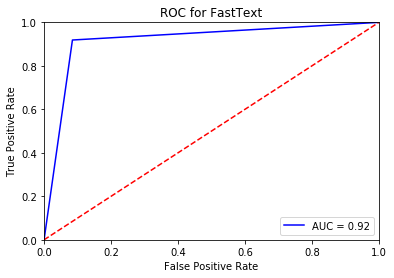

In [43]:
import matplotlib.pyplot as plt
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC for FastText')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Hard baseline

In [38]:
train_set = bz2.BZ2File("train.ft.txt.bz2")
train_set = train_set.readlines()
train_set = [x.decode('utf-8') for x in train_set]

test_set = bz2.BZ2File("test.ft.txt.bz2")
test_set = test_set.readlines()
test_set = [x.decode('utf-8') for x in test_set]

train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_set]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_set]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_set]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_set]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])
                                                       
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [39]:
cv = CountVectorizer(binary = True)
cv.fit(train_sentences)
log_train=cv.transform(train_sentences)
log_test =cv.transform(test_sentences)

In [40]:
lr = LogisticRegression()
lr.fit(log_train, train_labels)

C:\Users\Forest_Gump\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Result for hard baseline

In [41]:
roc_auc_LR=(roc_auc_score(test_labels, lr.predict(log_test)))
fpr1, tpr1, thresh1 = metrics.roc_curve(test_labels, lr.predict(log_test))
print("ROC AUC for LogisticRegression is", roc_auc_LR)

ROC AUC for LogisticRegression is 0.90548


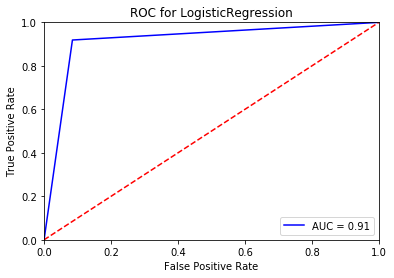

In [42]:
roc_auc1 = metrics.auc(fpr1, tpr1)
plt.title('ROC for LogisticRegression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### NN 

In [100]:
#importing everything necessary and not necessary
import tensorflow as tf
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, CuDNNLSTM
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('test.ft.txt.bz2')

In [4]:
case = re.compile(r'[\W]')
punct = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = case.sub(r' ', lower)
        no_non_ascii = punct.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

In [5]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, random_state=123, test_size=0.2)

In [7]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_texts)

In [8]:
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [9]:
maximum_length = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=maximum_length)
val_texts = pad_sequences(val_texts, maxlen=maximum_length)
test_texts = pad_sequences(test_texts, maxlen=maximum_length)

In [10]:
def build_model():
    sequences = layers.Input(shape=(maximum_length,))
    embedded = layers.Embedding(20000, 64)(sequences)
    x = layers.Conv1D(64, 3, activation='relu')(embedded)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(3)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
    
CNN = build_model()

In [11]:
CNN.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=2,
    validation_data=(val_texts, val_labels), )

Train on 2880000 samples, validate on 720000 samples
Epoch 1/2
2880000/2880000 [==============================] - 3755s 1ms/sample - loss: 0.1648 - binary_accuracy: 0.9377 - val_loss: 0.1461 - val_binary_accuracy: 0.9456
Epoch 2/2
2880000/2880000 [==============================] - 3806s 1ms/sample - loss: 0.1419 - binary_accuracy: 0.9479 - val_loss: 0.1415 - val_binary_accuracy: 0.9480


#### Result for CNN

In [14]:
preds = CNN.predict(test_texts)
import sklearn.metrics as metrics
roc_auc_CNN = roc_auc_score(test_labels, preds)
fpr2, tpr2, thresh2 = metrics.roc_curve(test_labels, preds)
print('ROC AUC for CNN is', roc_auc_CNN)

ROC AUC for CNN is 0.9871765808124999


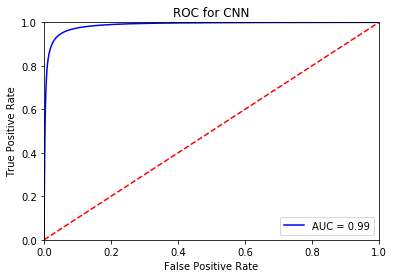

In [37]:
import matplotlib.pyplot as plt
roc_auc2 = metrics.auc(fpr2, tpr2)
plt.title('ROC for CNN')
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### A new view on fast text

In [68]:
MAX_LEN=maximum_length
def make_fast_text():
    fast_text = Sequential()
    fast_text.add(InputLayer((MAX_LEN,))) 
    fast_text.add(Embedding(20000, output_dim=300, trainable=True))
    fast_text.add(SpatialDropout1D(0.5))
    fast_text.add(GlobalMaxPooling1D())
    fast_text.add(Dropout(0.5))
    fast_text.add(Dense(2,activation='softmax'))
    return fast_text

fasttextmodel = make_fast_text()

fasttextmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [69]:
fasttextmodel.fit ( 
    train_texts, 
    train_labels,
    epochs=1,
    callbacks=[EarlyStopping(monitor='acc', min_delta=0.0001, patience=0, verbose=0)]
               )

C:\Users\Forest_Gump\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
2880000/2880000 [==============================] - 11538s 4ms/step - loss: 0.3006 - acc: 0.8731


In [95]:
FTpreds = fasttextmodel.predict(test_texts)

In [93]:
FTpreds 

array([[3.6294919e-02, 9.6370512e-01],
       [1.4691901e-02, 9.8530811e-01],
       [8.3673048e-01, 1.6326952e-01],
       ...,
       [8.5421097e-01, 1.4578900e-01],
       [5.5820029e-04, 9.9944180e-01],
       [9.7985315e-01, 2.0146824e-02]], dtype=float32)

#### As we see, I am not a very clever girl, and at the moment we have only probs, so let's make a list of classes manually

In [96]:
y_test_pred_classes = np.array([(FTpreds[i][1]>0.50).astype(int) for i in range(len(test_texts))])
y_test_pred_classes[:4]

array([1, 1, 0, 1])

In [98]:
roc_auc_fastt = roc_auc_score(test_labels, y_test_pred_classes)
fpr3, tpr3, thresh3 = metrics.roc_curve(test_labels, y_test_pred_classes)
print('ROC AUC for New Fast Text is', roc_auc_fastt)

ROC AUC for New Fast Text is 0.8961524999999999


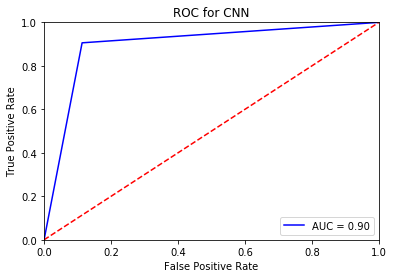

In [99]:
import matplotlib.pyplot as plt
roc_auc3 = metrics.auc(fpr3, tpr3)
plt.title('ROC for CNN')
plt.plot(fpr3, tpr3, 'b', label = 'AUC = %0.2f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### As usually, more tortures = worse result, since the very first fast text model gave much better results.

### LSTM works, however, ETA is about 104 hours, and resources of my computer are strongly limited, so I decided to interrupt it with accuracy = 0.87. Unfortunately, for LSTM model ROC AUC score cannot be estimated, but I suppose that it would be quite high, since LSTM usually demonstrates very good results on such tasks.

In [66]:
from keras.layers import Bidirectional
from keras.layers.normalization import BatchNormalization
def make_model_lstm():
    model_lstm = Sequential()
    model_lstm.add(InputLayer((MAX_LEN,))) 
    model_lstm.add(Embedding(20000, output_dim=300, trainable=True))
    model_lstm.add(LSTM(512))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(2,activation='softmax'))
    return model_lstm

model_lstm = make_model_lstm()

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [67]:
model_lstm.fit ( 
    train_texts, 
    train_labels,
    epochs=1,
    callbacks=[EarlyStopping(monitor='acc', min_delta=0.0001, patience=0, verbose=0)]
               )

C:\Users\Forest_Gump\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
 126304/2880000 [>.............................] - ETA: 83:49:34 - loss: 0.3152 - acc: 0.8669

KeyboardInterrupt: 

### All in all, we have following ROC AUC Scores:
### 1) Fasttext (soft baseline) = 91.73 and New Fast Text: 89.63
### 2) Count Vectorizer + simple Logistic Regression (as hard baseline) = 90.55
### 3) CNN = 98.74

### Therefore, the best result is obtained with neural network.

Heavily based on: https://www.kaggle.com/ejlok1/fasttext-model-91-7, https://www.kaggle.com/saishan/sentiment-analysis-logregre-vs-cudnnlstm